## What is OMSnx?

> OSMnx is a Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. 


OSMnx provides tools for
* Downloading geospatial data from OpenStreetMap (OSM)
    * Street network (with metadata)
    * Points of interest (e.g., stores)
* Modeling OSM street networks as NetworkX graphs
* (Street-)network simplification and clean up
* Basic routing
* Visualization

It bases on
* NetworkX (street network representation)
* GeoPandas (collections of geometries25)
* Shapely (geometry representation)
* Matplotlib (plotting)

## OSMnx Tutorial

Case study: How well is waste container coverage of the city of munich. Steps:

* Get boundaries/area of munich
* Find all waste containers within this area
* Determine the area covered by these

First, import the required libraries:

In [48]:
# Hide warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import geopandas as gpd
import osmnx as osm
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

# Display plots in notebook
%matplotlib inline

### Getting boundaries of Munich

OSMnx provides the `geocode_to_gdf()` function to query OSM:

> Retrieve place(s) by name or ID from the Nominatim API as a GeoDataFrame. You can query by place name or OSM ID. If querying by place name, the query argument can be a string or structured dict, or a list of such strings/dicts to send to geocoder.
    
#### Parameters
* **query** : `string` or dict or list query string(s) or structured dict(s) to geocode
* **which_result** : `int`, which geocoding result to use. if None, auto-select the first (Multi)Polygon or raise an error if OSM doesn't return one. to get the top match regardless of geometry type, set which_result=1
* **by_osmid** : `bool`, if True, handle query as an OSM ID for lookup rather than text search
* **buffer_dist** : `float`, distance to buffer around the place geometry, in meters
* **Returns**: a `GeoDataFrame` with one row for each query

Lets utilize it to get the boundaries of the city of munich.

In [49]:
munich = osm.geocode_to_gdf({
    'city': 'München',
    'state': 'Bayern',
    'Country': 'Deutschland'
})

munich

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"MULTIPOLYGON (((11.36078 48.15807, 11.36085 48...",48.248116,48.061624,11.72291,11.360777,143612795,relation,62428,48.137108,11.575382,boundary,administrative,12,0.746211,city,Munich,"Munich, Bavaria, Germany"


We can now use geopandas to plot the area:

Text(24.952920273745377, 0.5, 'latitude')

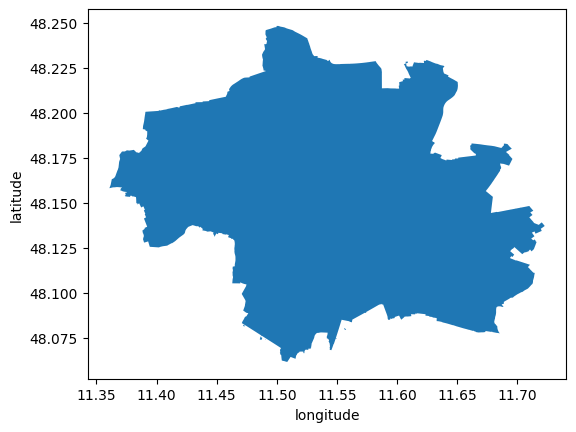

In [51]:
munich.plot()
plt.xlabel("longitude")
plt.ylabel("latitude")

## Getting geospatial data

OSMnx is not limited to querying for boundaries. Instead, we can query (arbitrary) data from [OSM](https://wiki.openstreetmap.org/wiki/Map_features) based on ***tags***.

Let's find all (glass) waste containers in munich:

In [52]:
# We can query for arbitrary objects using tags:
containers = osm.geometries_from_place('München, Bayern', {'amenity': 'recycling'})
print(len(containers))
containers.head(10)

#These are the input from users, so better inspect the data before using it 

1102


amenity    location recycling:cans  \
element_type osmid                                             
node         48053986   recycling  overground            yes   
             51971057   recycling         NaN            yes   
             115721294  recycling  overground            NaN   
             171477009  recycling  overground            yes   
             185969408  recycling         NaN            NaN   
             206305422  recycling         NaN            NaN   
             206305460  recycling         NaN            yes   
             206306093  recycling         NaN            yes   
             206307699  recycling         NaN            yes   
             206310894  recycling         NaN            yes   

                       recycling:clothes recycling:glass_bottles  \
element_type osmid                                                 
node         48053986                yes                     yes   
             51971057                yes                     yes   
             115721294               yes                     yes   
             171477009               NaN                     yes   
             185969408               NaN                     NaN   
             206305422               yes                     yes   
             206305460               yes                     yes   
             206306093               yes                     yes   
             206307699               NaN                     yes   
             206310894               NaN                     yes   

                       recycling:plastic recycling:shoes recycling_type  \
element_type osmid                                                        
node         48053986                yes             yes      container   
             51971057                NaN             yes      container   
             115721294               yes             NaN      container   
             171477009                no             NaN      container   
             185969408               NaN             NaN      container   
             206305422                no             NaN      container   
             206305460                no             NaN      container   
             206306093               yes             NaN      container   
             206307699               yes             NaN      container   
             206310894               yes             NaN      container   

                                         geometry recycling:batteries  ...  \
element_type osmid                                                     ...   
node         48053986   POINT (11.59985 48.20554)                 NaN  ...   
             51971057   POINT (11.60533 48.20207)                  no  ...   
             115721294  POINT (11.54579 48.13728)                 NaN  ...   
             171477009  POINT (11.51170 48.17253)                 NaN  ...   
             185969408  POINT (11.58006 48.15700)                 NaN  ...   
             206305422  POINT (11.54730 48.12694)                 NaN  ...   
             206305460  POINT (11.55310 48.13013)                 NaN  ...   
             206306093  POINT (11.55189 48.11609)                 NaN  ...   
             206307699  POINT (11.54708 48.11034)                 NaN  ...   
             206310894  POINT (11.54630 48.11186)                 NaN  ...   

                       recycling:computers recycling:fluorescent_tubes  \
element_type osmid                                                       
node         48053986                  NaN                         NaN   
             51971057                  NaN                         NaN   
             115721294                 NaN                         NaN   
             171477009                 NaN                         NaN   
             185969408                 NaN                         NaN   
             206305422                 NaN                         NaN   
          

<AxesSubplot:>

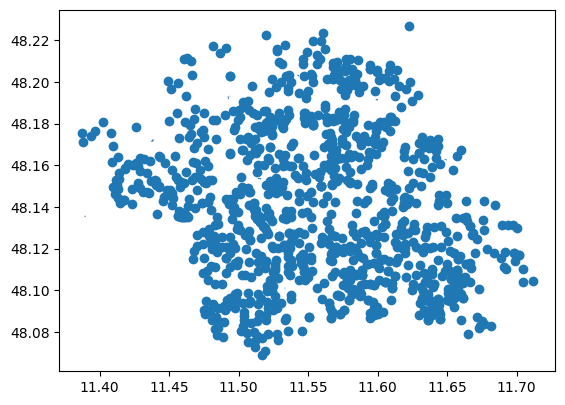

In [36]:
containers.plot()

**Caveat**: `amenity: recycling` comprises not only glass waste containers *(Know your data!)*

In [37]:
# Check that there are other data than containers
non_containers = containers[containers['recycling_type'] != 'container']
print(len(non_containers))
non_containers.head(4)

64


amenity location recycling:cans recycling:clothes  \
element_type osmid                                                            
node         224094533  recycling      NaN            yes               yes   
             289205704  recycling      NaN            NaN               NaN   
             439808286  recycling      NaN            yes               NaN   
             471192394  recycling      NaN            yes               NaN   

                       recycling:glass_bottles recycling:plastic  \
element_type osmid                                                 
node         224094533                     NaN               NaN   
             289205704                     NaN               NaN   
             439808286                     NaN               NaN   
             471192394                     NaN               NaN   

                       recycling:shoes recycling_type  \
element_type osmid                                      
node         224094533             NaN         centre   
             289205704             NaN            NaN   
             439808286             NaN            NaN   
             471192394             NaN            NaN   

                                         geometry recycling:batteries  ...  \
element_type osmid                                                     ...   
node         224094533  POINT (11.62278 48.22681)                 yes  ...   
             289205704  POINT (11.48383 48.17252)                 NaN  ...   
             439808286  POINT (11.49083 48.14366)                 NaN  ...   
             471192394  POINT (11.49167 48.14358)                 NaN  ...   

                       recycling:computers recycling:fluorescent_tubes  \
element_type osmid                                                       
node         224094533                 NaN                         NaN   
             289205704                 NaN                         NaN   
             439808286                 NaN                         NaN   
             471192394                 NaN                         NaN   

                       recycling:mobile_phones recycling:paint  \
element_type osmid                                               
node         224094533                     NaN             NaN   
             289205704                     NaN             NaN   
             439808286                     NaN             NaN   
             471192394                     NaN             NaN   

                       recycling:rubble addr:housename layer building:levels  \
element_type osmid                                                             
node         224094533              NaN            NaN   NaN             NaN   
             289205704              NaN            NaN   NaN             NaN   
             439808286              NaN            NaN   NaN             NaN   
             471192394              NaN            NaN   NaN             NaN   

                       height roof:shape  
element_type osmid                        
node         224094533    NaN        NaN  
             289205704    NaN        NaN  
             439808286    NaN        NaN  
             471192394    NaN        NaN  

[4 rows x 104 columns]

Any ideas?

Let's try combining tags:

In [38]:
actual_containers = osm.geometries_from_place('München, Bayern', {'amenity': 'recycling', 'recycling_type': 'container'})
len(actual_containers)

#In this case it does "OR" so actually extend the entries 

1104

In [1]:
# lines above return union! -- let's filter the dataframe
containers = containers[containers['recycling_type'] == 'container']
containers = containers[containers['recycling:glass_bottles	'] == 'yes']

containers.head(4)

NameError: name 'containers' is not defined

## Working with Geospatial data

#### => How well is munich covered?

<AxesSubplot:>

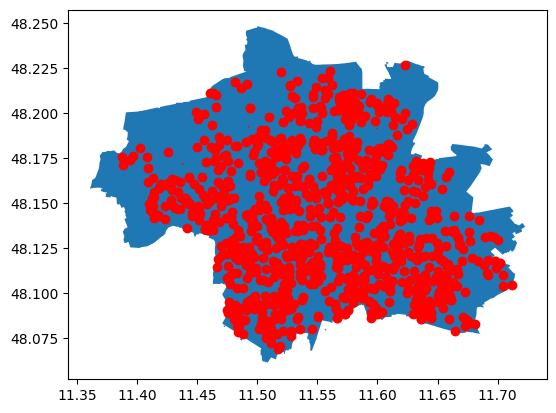

In [53]:
# Print container locations over munich map
ax = munich.plot()
containers.plot(ax=ax, color='r') #ax is a standard that we have to pass
#They habe the same coordinate reference system (CRS)

C:\Users\anton\AppData\Local\Temp\ipykernel_15000\1182372495.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas_covered = containers.buffer(500)


<AxesSubplot:>

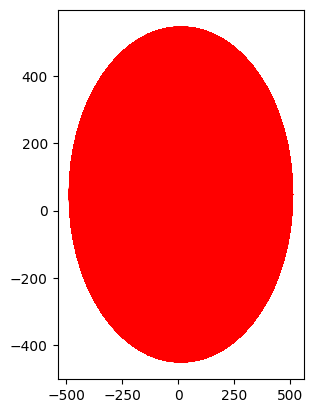

In [56]:
# Lets try to plot coverage
areas_covered = containers.buffer(500) # 500 is the radius of the buffer and too large!
ax = munich.plot()
areas_covered.plot(ax=ax, color='r')

**Problem**: We buffer by a lat/long of 500 meters!

Again, OSMnx to the rescue! We can *project* `GeoDataFrames` into different coordinate reference systems (CRS), i.e., one based on meters:

In [57]:
# Containers is in lat/lon! => Project to meters
containers_meters = osm.project_gdf(containers, to_crs = ) #we can find it by searching "cs epsg"  
display(containers_meters.head(4))

#Here geometry shows the distance 

amenity    location recycling:cans  \
element_type osmid                                             
node         48053986   recycling  overground            yes   
             51971057   recycling         NaN            yes   
             115721294  recycling  overground            NaN   
             171477009  recycling  overground            yes   

                       recycling:clothes recycling:glass_bottles  \
element_type osmid                                                 
node         48053986                yes                     yes   
             51971057                yes                     yes   
             115721294               yes                     yes   
             171477009               NaN                     yes   

                       recycling:plastic recycling:shoes recycling_type  \
element_type osmid                                                        
node         48053986                yes             yes      container   
             51971057                NaN             yes      container   
             115721294               yes             NaN      container   
             171477009                no             NaN      container   

                                              geometry recycling:batteries  \
element_type osmid                                                           
node         48053986   POINT (693157.895 5342413.372)                 NaN   
             51971057   POINT (693578.595 5342041.729)                  no   
             115721294  POINT (689393.190 5334692.733)                 NaN   
             171477009  POINT (686729.604 5338527.635)                 NaN   

                        ... recycling:computers recycling:fluorescent_tubes  \
element_type osmid      ...                                                   
node         48053986   ...                 NaN                         NaN   
             51971057   ...                 NaN                         NaN   
             115721294  ...                 NaN                         NaN   
             171477009  ...                 NaN                         NaN   

                       recycling:mobile_phones recycling:paint  \
element_type osmid                                               
node         48053986                      NaN             NaN   
             51971057                      NaN             NaN   
             115721294                     NaN             NaN   
             171477009                     NaN             NaN   

                       recycling:rubble addr:housename layer building:levels  \
element_type osmid                                                             
node         48053986               NaN            NaN   NaN             NaN   
             51971057               NaN            NaN   NaN             NaN   
             115721294              NaN            NaN   NaN             NaN   
             171477009              NaN            NaN   NaN             NaN   

                       height roof:shape  
element_type osmid                        
node         48053986     NaN        NaN  
             51971057     NaN        NaN  
             115721294    NaN        NaN  
             171477009    NaN        NaN  

[4 rows x 104 columns]

<AxesSubplot:>

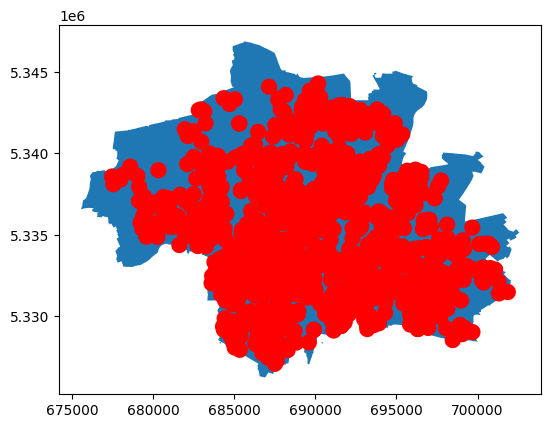

In [43]:
areas_covered = containers_meters.buffer(500)
munich_meters = osm.project_gdf(munich)
ax = munich_meters.plot()
areas_covered.plot(ax=ax, color='r')

## Answering the question

#### How well is munich covered by waste disposal containers?

<AxesSubplot:>

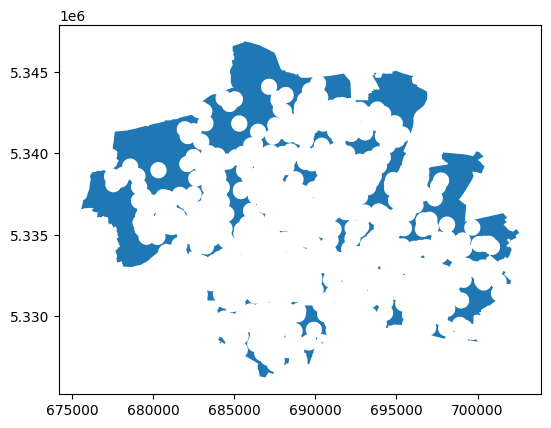

In [44]:
# Get uncovered area
covered_area = areas_covered.unary_union
uncovered_area = munich_meters.difference(covered_area)#Substract from original. multipolygon - multipolygon
uncovered_area.plot()
#uncovered_area = munich_meters.iloc[0].geometry.difference(covered_area). this also works 

In [77]:
print(f'Uncovered area: {uncovered_area.area[0]:.2f}, of total: {munich_meters.area[0]:.2f} => {(uncovered_area.area[0] / munich_meters.area[0]):.2%}')

Uncovered area: 83837067.09, of total: 310738200.64 => 26.98%


### Overview of geopandas/shapely methods
See further: [Documentation](https://shapely.readthedocs.io/en/latest/manual.html)

#### Construction
* buffer
* unary_union
* convex_hull

#### Set theoretic operations
* difference
* intersection
* union
* centroid

#### Geospatial relations
* contains
* covers
* intersects

## Getting the street network

In [79]:
munich_streets = osm.graph_from_place('Maxvorstadt, Munich, Germany', network_type='drive')
# What are we dealing with?
print(type(munich_streets))
# Get some info on the graph
print(munich_streets)

<class 'networkx.classes.multidigraph.MultiDiGraph'>
MultiDiGraph with 350 nodes and 789 edges


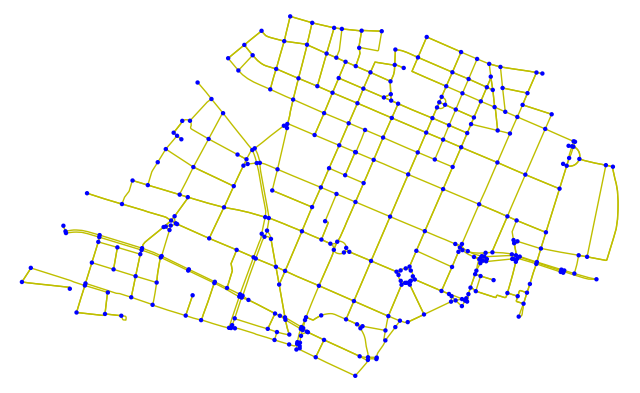

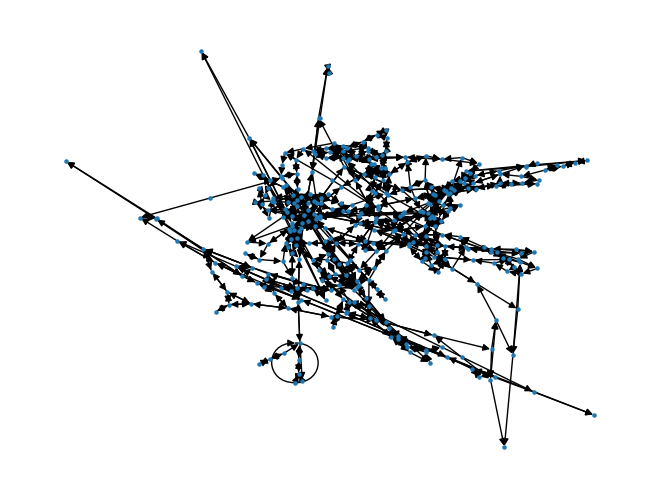

In [90]:
osm.plot_graph(munich_streets, node_size=10, bgcolor="none", edge_color="y", node_color="b") #preferred option
nx.draw(munich_streets, node_size=5)

What data does this graph carry?

In [91]:
nodes, edges = osm.graph_to_gdfs(munich_streets)
display(nodes.head(4))
display(edges.head(4))

,y,x,street_count,highway,geometry
osmid,,,,,
361775,48.140652,11.566377,4,NaN,POINT (11.56638 48.14065)
361776,48.140699,11.565757,3,NaN,POINT (11.56576 48.14070)
361779,48.142145,11.561450,4,NaN,POINT (11.56145 48.14215)
361780,48.142624,11.560228,4,NaN,POINT (11.56023 48.14262)


osmid  oneway           name    highway maxspeed  \
u      v        key                                                         
361775 21026697 0    299257170    True  Sophienstraße   tertiary       50   
       361776   0    252377910    True   Elisenstraße  secondary       50   
361776 21642943 0    146913739   False   Elisenstraße  secondary       50   
       21026697 0    146913740    True   Elisenstraße  secondary       50   

                    reversed   length lanes  \
u      v        key                           
361775 21026697 0      False   14.963   NaN   
       361776   0      False   46.540     1   
361776 21642943 0      False  215.369     2   
       21026697 0      False   49.712     2   

                                                              geometry width  \
u      v        key                                                            
361775 21026697 0    LINESTRING (11.56638 48.14065, 11.56636 48.14052)   NaN   
       361776   0    LINESTRING (11.56638 48.14065, 11.56626 48.140...   NaN   
361776 21642943 0    LINESTRING (11.56576 48.14070, 11.56547 48.140...   NaN   
       21026697 0    LINESTRING (11.56576 48.14070, 11.56606 48.140...   NaN   

                    tunnel junction access  
u      v        key                         
361775 21026697 0      NaN      NaN    NaN  
       361776   0      NaN      NaN    NaN  
361776 21642943 0      NaN      NaN    NaN  
       21026697 0      NaN      NaN    NaN

Street networks as returned by OSMnx are just NetworkX graphs with additional data!

**=> We can use all of NetworkX's functions on the street network!**

In [92]:
top_nodes = [node for node, deg in sorted(munich_streets.degree, key=lambda x: x[1], reverse=True)[:10]]
top_nodes

[363191,
 1954405,
 1955467,
 1955504,
 1955506,
 1956111,
 6730035,
 6730036,
 6730038,
 7983325]

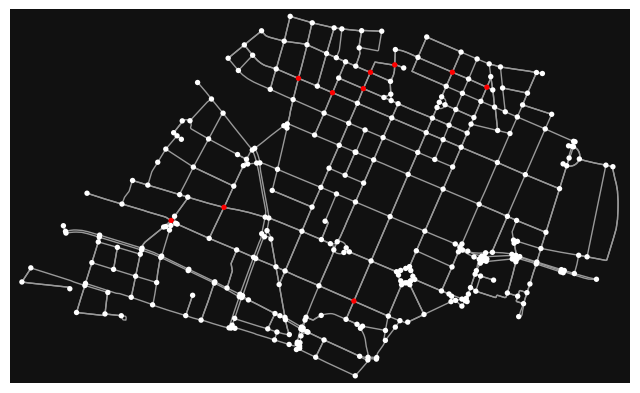

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [93]:
osm.plot_graph(munich_streets, node_color=['r' if node in top_nodes else 'w' for node in munich_streets])

Let's take a closer look on the network...

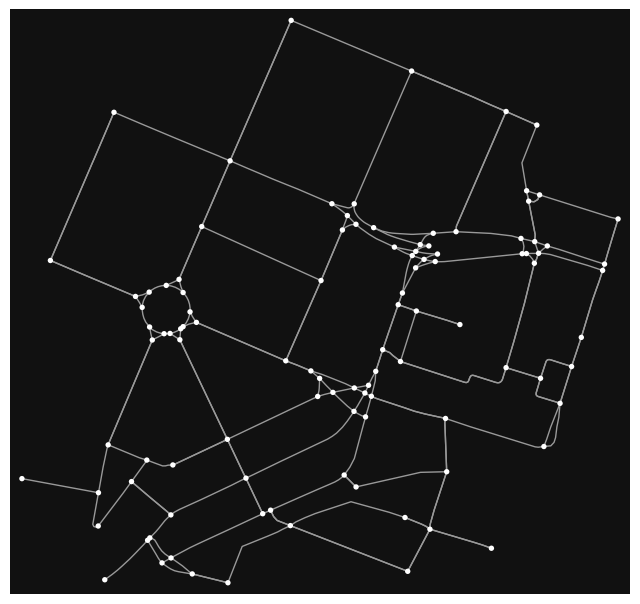

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [94]:
karolinenplatz_coords = (48.145136, 11.572600)
karolinenplatz = osm.graph_from_point(karolinenplatz_coords, dist=500, network_type='drive')
osm.plot_graph(karolinenplatz)

 **Lots of superfluous nodes!**

OSMnx already does ***some*** sparsification in the background:

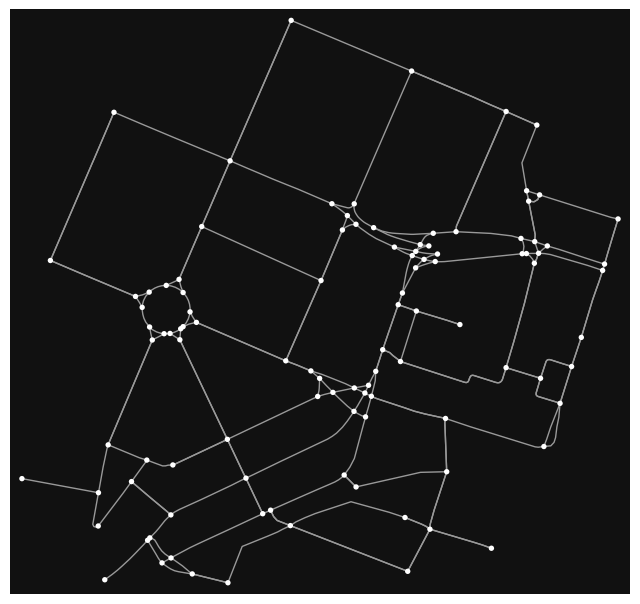

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [101]:
raw_karolinenplatz = osm.graph_from_point(karolinenplatz_coords, network_type='drive', dist=500,
                                          simplify=False,  # Discard intermediate nodes
                                          retain_all=True  # Keep all connected components
                                          )
osm.plot_graph(karolinenplatz)

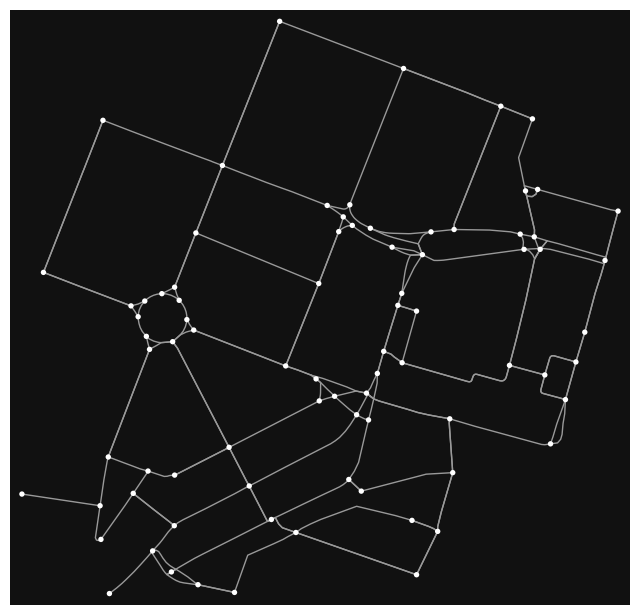

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [102]:
# But we can do better!
projected_karolinenplatz = osm.project_graph(karolinenplatz)
clean_karolinenplatz = osm.consolidate_intersections(projected_karolinenplatz, rebuild_graph=True, tolerance=10, dead_ends=False)
#fig, ax = osm.plot_graph(projected_karolienplatz, node_color='r', show=False, close=False)
osm.plot_graph(clean_karolinenplatz)

## Basic routing

OSMnx provides facets for basic routing: `shortest_path(G, origin, dest, weight='length')`. Here, `origin` and `dest` are nodes of the graph (i.e., of type `osmid`).

In [103]:
query = osm.geocode_to_gdf(['Arcisstraße 21, 80333 München', 'Maßmannstraße 8, 80333 München'])
display(query)
university, park = (query.iloc[0], query.iloc[1])

,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((11.56561 48.14836, 11.56691 48.14799...",48.151406,48.147005,11.569907,11.565609,143022636,way,144291476,48.149073,11.567445,amenity,university,30,0.544239,amenity,Technical University Munich,"Technical University Munich, 21, Arcisstraße, ..."
1,"POLYGON ((11.55952 48.15168, 11.55961 48.15161...",48.151763,48.151609,11.559762,11.559524,143507566,way,106529828,48.151686,11.559643,building,yes,30,0.000010,building,,"8, Maßmannstraße, Augustenstraße, Maxvorstadt,..."


We need to map these locations to nodes in our street network. OSMnx provides the `distance.nearest_nodes(graph, lon, lat)` function for this.

In [124]:
university_node = osm.nearest_nodes(munich_streets, university.lon,university.lat)
park_node = osm.nearest_nodes(munich_streets, park.lon,park.lat)
print(university_node, park_node)

21457468 246879854


This gives us the OSM ID's of the closest node(s).

We can use these with the shortest path function:

[21457468, 21457467, 1954396, 4972204765, 4972221472, 1955498, 246879854]

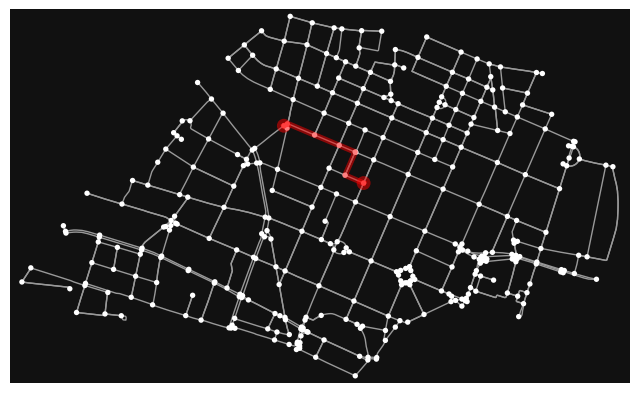

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [125]:
shortest_path = osm.shortest_path(munich_streets, orig=university_node, dest=park_node, weight='length')
display(shortest_path)

osm.plot_graph_route(munich_streets, route=shortest_path)

Finally, we can get the length of the shortest path:

In [127]:
route_length = osm.utils_graph.get_route_edge_attributes(munich_streets, shortest_path, 'length')
print(f'Length of edges: {route_length}, total: {sum(route_length):.2f} meters')

Length of edges: [110.326, 138.791, 95.22699999999999, 146.704, 162.142, 21.33], total: 674.52 meters


## Putting it together: Diet-aware routing

Let's design a routing engine that tries to minimize the number of (fast-food) restaurants the route visits. For this purpose we need to:

* Get the street network
* Fetch the locations of fast food restaurants
* Determine which streets should be avoided
* Find shortest paths accordingly

We start by assembling the street network:

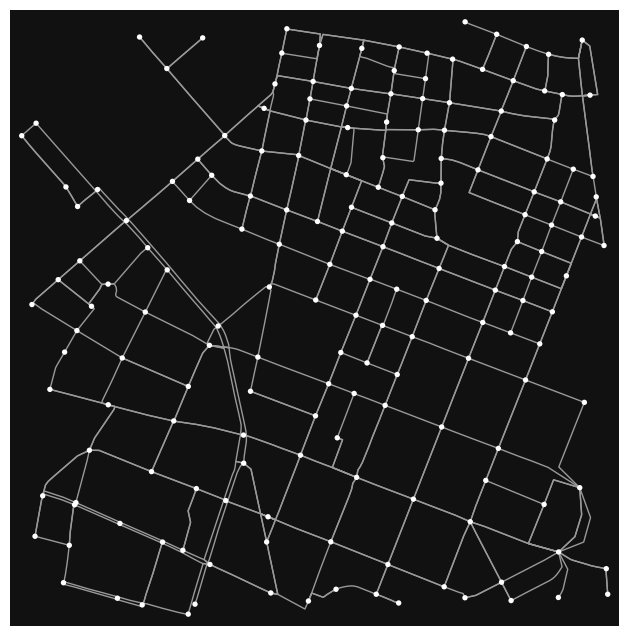

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [129]:
network = osm.graph_from_address('Maxvorstadt, Munich, Germany', network_type='drive')
# We'll want to work with reasonable distances
network = osm.project_graph(network)
# Simplify intersections
network = osm.consolidate_intersections(network, rebuild_graph=True, dead_ends=False, tolerance=30)

osm.plot_graph(network)

We'll also need speeds. Here, we can again rely on built-in OSMnx functions.

In [130]:
nodes, edges = osm.graph_to_gdfs(network)
display(edges.head(4))

osmid  oneway   lanes  \
u v  key                                                        
0 1  0      [313579584, 292950402, 313579583]    True  [3, 2]   
  64 0                 [944294209, 944294210]    True       2   
  67 0    [203140769, 1212520835, 1137180558]   False     NaN   
1 2  0                  [1114967642, 4000324]   False       2   

                     name      highway maxspeed reversed      length  \
u v  key                                                               
0 1  0       Elisenstraße    secondary       50    False  159.915219   
  64 0       Luisenstraße  residential       50    False  216.468734   
  67 0      Sophienstraße  residential       30     True  122.619592   
1 2  0    Dachauer Straße  residential       50     True  207.945430   

                                                   geometry  u_original  \
u v  key                                                                  
0 1  0    LINESTRING (690552.292 5335299.907, 690540.272...      361779   
  64 0    LINESTRING (690552.292 5335299.907, 690563.428...  2131150292   
  67 0    LINESTRING (690552.292 5335299.907, 690563.428...  2131150292   
1 2  0    LINESTRING (690423.475 5335327.509, 690447.614...      361780   

          v_original width tunnel access  
u v  key                                  
0 1  0        361780   NaN    NaN    NaN  
  64 0      11310368   NaN    NaN    NaN  
  67 0    2131147707   NaN    NaN    NaN  
1 2  0    1241343853   NaN    NaN    NaN

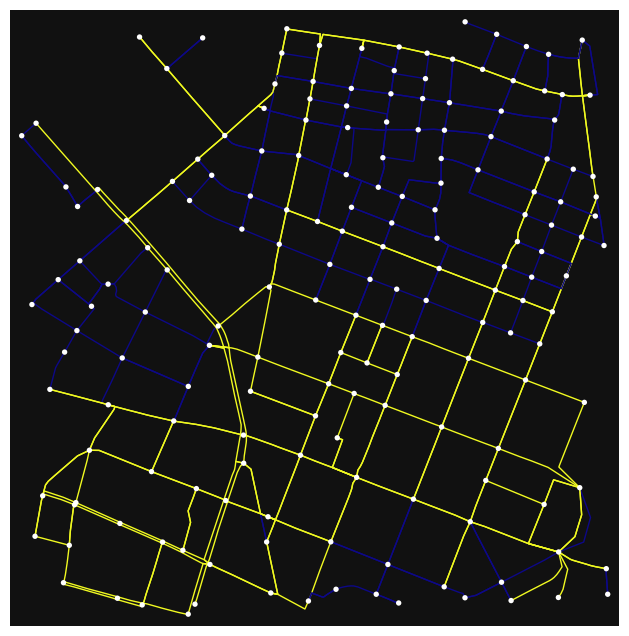

(<Figure size 800x800 with 1 Axes>, <AxesSubplot:>)

In [144]:
network = osm.add_edge_speeds(network, hwy_speeds={
    'residential': 30,
    'unclassified': 30,
    'tertiary': 50,
    'secondary': 70,
    'trunk': 120,
    'primary': 100,
    'motorway': 130
}, fallback=30)
# This adds a 'speed_kph' attribute to each edgea
# We can use this to calculate the travel time
network = osm.add_edge_travel_times(network, precision=2)
osm.plot_graph(network, edge_color=osm.plot.get_edge_colors_by_attr(network, attr='speed_kph', cmap="plasma"))


In [145]:
nodes, edges = osm.graph_to_gdfs(network)
edges.head(4)

osmid  oneway   lanes  \
u v  key                                                        
0 1  0      [313579584, 292950402, 313579583]    True  [3, 2]   
  64 0                 [944294209, 944294210]    True       2   
  67 0    [203140769, 1212520835, 1137180558]   False     NaN   
1 2  0                  [1114967642, 4000324]   False       2   

                     name      highway maxspeed reversed      length  \
u v  key                                                               
0 1  0       Elisenstraße    secondary       50    False  159.915219   
  64 0       Luisenstraße  residential       50    False  216.468734   
  67 0      Sophienstraße  residential       30     True  122.619592   
1 2  0    Dachauer Straße  residential       50     True  207.945430   

                                                   geometry  u_original  \
u v  key                                                                  
0 1  0    LINESTRING (690552.292 5335299.907, 690540.272...      361779   
  64 0    LINESTRING (690552.292 5335299.907, 690563.428...  2131150292   
  67 0    LINESTRING (690552.292 5335299.907, 690563.428...  2131150292   
1 2  0    LINESTRING (690423.475 5335327.509, 690447.614...      361780   

          v_original  speed_kph  travel_time width tunnel access  
u v  key                                                          
0 1  0        361780       50.0        11.51   NaN    NaN    NaN  
  64 0      11310368       50.0        15.59   NaN    NaN    NaN  
  67 0    2131147707       30.0        14.71   NaN    NaN    NaN  
1 2  0    1241343853       50.0        14.97   NaN    NaN    NaN

### Getting fast-food restaurant locations

Similar to the waste disposal container case study, we fetch the geometries according to OSM *tags*:

In [165]:
shops_in_area = osm.geometries_from_address('Maxvorstadt, Munich, Germany', tags={
    'amenity': ['fast_food'] # 'restaurant'
})
# Project to meters
shops_in_area = osm.project_gdf(shops_in_area)
shops_in_area = shops_in_area.reset_index(level=["osmid","element_type"]) # move index to columns
display(shops_in_area)

,element_type,osmid,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,amenity,cuisine,diet:vegetarian,...,payment:cards,diet:healthy,website:menu,website:orders,payment:contactless,contact:mobile,description,capacity,access,fast_food
0,node,244038459,München,DE,21,80333,Steinheilstraße,fast_food,sushi,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,node,315919420,München,NaN,24,80333,Rottmannstraße,fast_food,sushi;asian,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,node,332790697,München,DE,64,80333,Gabelsbergerstraße,fast_food,pizza,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,node,366122901,München,DE,144,80797,Georgenstraße,fast_food,thai,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,node,426878878,München,DE,46,80799,Barer Straße,fast_food,indian,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,node,10087595080,München,NaN,74,80333,Augustenstraße,fast_food,falafel;kebab,yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,node,10235158093,München,DE,56,80333,Theresienstraße,fast_food,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,+49 179 8766 786,"Bowls, Tortillas, Smoothies",NaN,NaN,NaN
64,node,10315950222,München,DE,5,80796,Kurfürstenplatz,fast_food,pizza,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Pizza zur Abholung ; Telefonische Vorbestellun...,0,NaN,NaN
65,node,11232208078,München,NaN,1,80333,Bernd-Eichinger-Platz,fast_food,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,cafeteria


In [166]:
# What does our data look like?
print(shops_in_area.columns)
shops_in_area[['osmid', 'name', 'addr:street', 'addr:housenumber', 'geometry']].tail(5)

Index(['element_type', 'osmid', 'addr:city', 'addr:country',
       'addr:housenumber', 'addr:postcode', 'addr:street', 'amenity',
       'cuisine', 'diet:vegetarian', 'indoor_seating', 'name', 'opening_hours',
       'outdoor_seating', 'wheelchair', 'geometry', 'delivery',
       'delivery:partner', 'phone', 'takeaway', 'website', 'drive_through',
       'contact:phone', 'brand', 'brand:wikidata', 'diet:vegan', 'email',
       'contact:email', 'contact:website', 'wheelchair:description', 'smoking',
       'fixme', 'payment:ep_stwm_legic', 'check_date:opening_hours',
       'opening_hours:signed', 'level', 'source', 'air_conditioning',
       'brand:wikipedia', 'diet:meat', 'internet_access', 'layer',
       'toilets:wheelchair', 'old_name', 'internet_access:fee', 'check_date',
       'payment:cash', 'payment:girocard', 'start_date', 'toilets',
       'toilets:access', 'name:de', 'operator', 'diet:halal', 'fax',
       'contact:instagram', 'payment:mastercard', 'payment:visa', 'shop',


,osmid,name,addr:street,addr:housenumber,geometry
62,10087595080,DOA Kitchen & Farmshop,Augustenstraße,74,POINT (690686.948 5336177.762)
63,10235158093,Baruts Coffee and Bakery,Theresienstraße,56,POINT (691425.275 5336017.465)
64,10315950222,Forza Napoli,Kurfürstenplatz,5,POINT (691452.828 5337282.082)
65,11232208078,Cantina Conviva,Bernd-Eichinger-Platz,1,POINT (691098.459 5335800.889)
66,11232223274,Zentrum für Naturheilkunde - Kantine,Hirtenstraße,26,POINT (690210.256 5335309.300)


<AxesSubplot:>

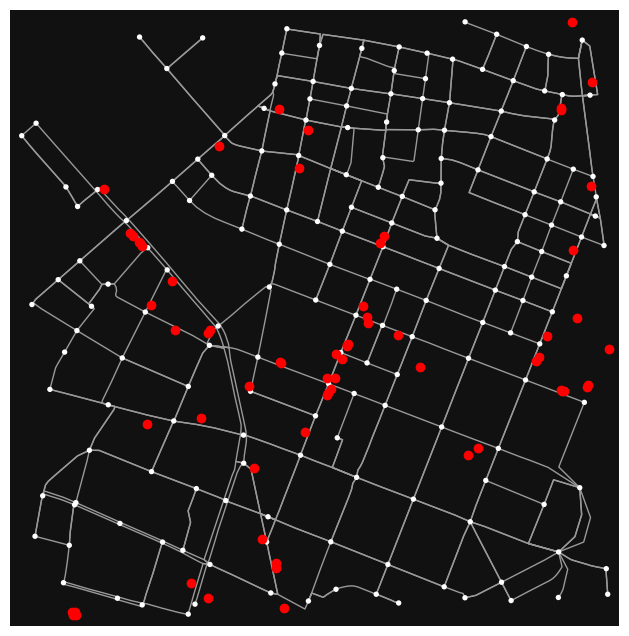

In [169]:
# Plot the locations on the street network
fig, ax = osm.plot_graph(network, show=False)
shops_in_area.plot(ax=ax, color='r')

### Mapping locations to the street network

This time, we need to determine the edges adjacent to each restaurant.

We could use the `get_nearest_edge()` function, but then we'd have only a single edge per restaurant.

Instead, we will "expand" the nodes to match the radius they cover, and then see which edges intersect these new geometric shapes.

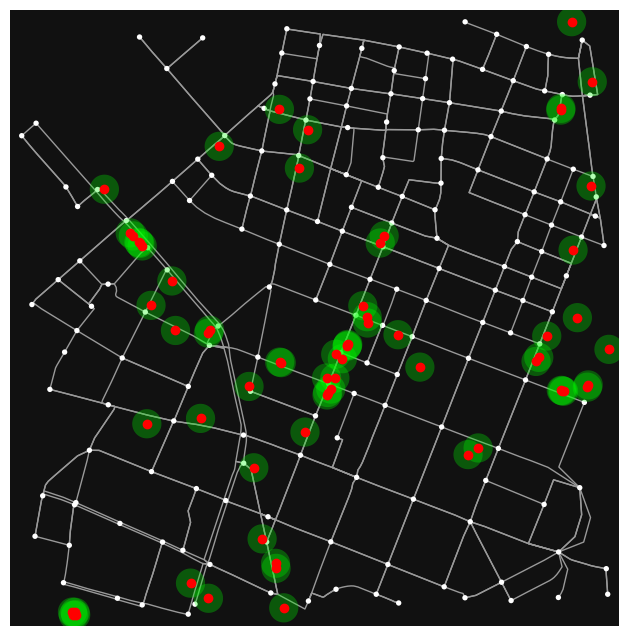

In [216]:
shops_in_area['vicinity'] = shops_in_area.buffer(distance=50) # creates a polygon for each shop

fig, ax = osm.plot_graph(network, show=False, close=False)
shops_in_area['vicinity'].plot(ax=ax, alpha=0.3, color='#00ff00')
shops_in_area.plot(ax=ax, color='r')

plt.show()
plt.close(fig)

Finally, determine which edges are being covered.

<AxesSubplot:>

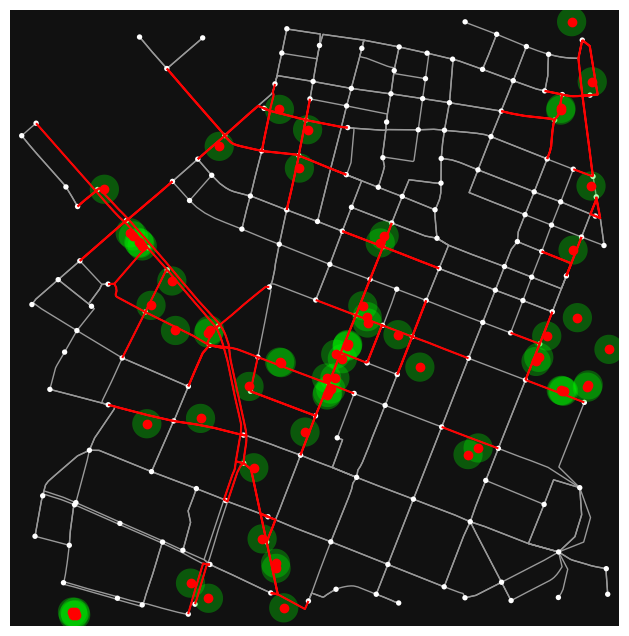

In [217]:
nodes, edges = osm.graph_to_gdfs(network)
edges['expensive'] = False
# Find edges in vicinity
for shop_id, shop in shops_in_area.iterrows():
    # edges.geometry.crosses(shop.vicinity) returns series of bools for every edge (True if edge cross the polygon around the shop)
    edges['expensive'] = edges['expensive'] | edges.geometry.crosses(shop.vicinity)
fig, ax = osm.plot_graph(network, show=False)
edges[edges['expensive']].plot(ax=ax, color='r')
shops_in_area['vicinity'].plot(ax=ax, alpha=0.3, color='#00ff00')
shops_in_area.plot(ax=ax, color='r')

### Assigning edge costs based on expensiveness

In [218]:
diet_factor = 10.0
edges['cost'] = edges['travel_time'] + (diet_factor * edges['travel_time'] * edges['expensive']) # add penalty if edge is close to fast food
nx.set_edge_attributes(network, values=edges['cost'], name = 'cost')
display(edges.tail(4))

osmid  oneway   lanes  \
u   v   key                                                      
175 143 0                            778925878    True       1   
    149 0                            100177587    True       1   
176 94  0                              4520027   False       2   
177 3   0    [313579601, 122926430, 122926431]    True  [4, 2]   

                         name      highway maxspeed reversed      length  \
u   v   key                                                                
175 143 0          Marsstraße    secondary       50    False  167.301934   
    149 0          Marsstraße    secondary       50    False  170.432454   
176 94  0    Infanteriestraße  residential       50    False  142.451000   
177 3   0         Seidlstraße    secondary       50    False  150.723218   

                                                      geometry  u_original  \
u   v   key                                                                  
175 143 0    LINESTRING (689907.284 5335565.374, 689905.667...   738257248   
    149 0    LINESTRING (689907.284 5335565.374, 689908.902...   738257233   
176 94  0    LINESTRING (689974.511 5337229.557, 689982.314...   679217457   
177 3   0    LINESTRING (690164.205 5335289.121, 690170.597...  1710336183   

             v_original  speed_kph  travel_time    cost width tunnel access  \
u   v   key                                                                   
175 143 0      21642946       50.0        12.05   12.05   NaN    NaN    NaN   
    149 0      21632162       50.0        12.27   12.27   NaN    NaN    NaN   
176 94  0     679217451       50.0        10.26   10.26   NaN    NaN    NaN   
177 3   0        361786       50.0        10.85  119.35   NaN    NaN    NaN   

             expensive  
u   v   key             
175 143 0        False  
    149 0        False  
176 94  0        False  
177 3   0         True

### Routing according to diet costs

First, resolve our "query".

In [219]:
# Let's redo our shortest path query!
#which_result (int) – if None, auto-select the first (Multi)Polygon or raise an error if OSM doesn’t return one.
# to get the top match regardless of geometry type, set which_result=1. -- we need it because the geometry of Arcistrasse is a linestring.
gdf_origin_destination = osm.geocode_to_gdf([
    dict(street='42 Arcisstraße', city='Munich', postalcode=80333, country='Germany'),
    dict(street='8 Maßmannstraße', city='Munich', country='Germany')
], which_result=1)
query = osm.project_gdf(gdf_origin_destination)

display(query)

university, park = (query.iloc[0], query.iloc[1])
university_node = osm.nearest_nodes(network, university.geometry.centroid.coords[0][0], university.geometry.centroid.coords[0][1])
park_node = osm.nearest_nodes(network, park.geometry.centroid.coords[0][0], park.geometry.centroid.coords[0][1])


,geometry,bbox_north,bbox_south,bbox_east,bbox_west,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"LINESTRING (690978.047 5335817.983, 690997.546...",48.147604,48.146917,11.568012,11.567573,143370469,way,344664988,48.147360,11.567858,highway,secondary,26,0.10001,road,Arcisstraße,"Arcisstraße, Königsplatz, Maxvorstadt, Munich,..."
1,"POLYGON ((690361.737 5336327.561, 690368.587 5...",48.151763,48.151609,11.559762,11.559524,143507566,way,106529828,48.151686,11.559643,building,yes,30,0.00001,building,,"8, Maßmannstraße, Augustenstraße, Maxvorstadt,..."


Finally, we can use the "cost" attribute to find a shortest path!

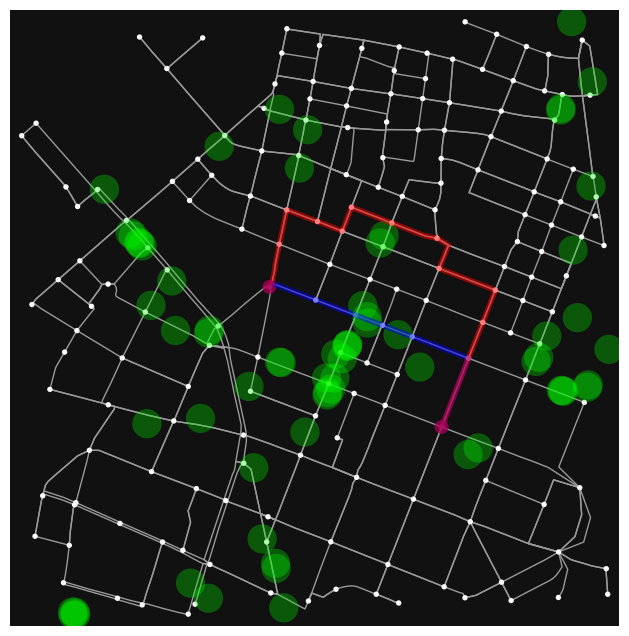

In [220]:
# Compute shortest paths
shortest_diet_path = osm.shortest_path(network, orig=university_node, dest=park_node, weight='cost')
shortest_path = osm.shortest_path(network, orig=university_node, dest=park_node, weight='travel_time')

fig, ax = osm.plot_graph_route(network, shortest_path, show=False, close=False, route_color='b')
osm.plot_graph_route(network, shortest_diet_path, ax=ax, show=False, close=False, route_color='r')
shops_in_area['vicinity'].plot(ax=ax, alpha=0.3, color='#00ff00')
plt.show()